In [1]:
#Importation des bibliotheques
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

from datasets import load_dataset

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

from model import Model

from tweet_dataset_v2 import TweetDataset
from neural_network_v1 import NeuralNetwork

Using cache found in C:\Users\Abdou/.cache\torch\hub\huggingface_pytorch-transformers_main


In [2]:
#Definition de constante
SEED = 42 

BATCH_SIZE = 64 

DEVICE = "cuda" if torch.cuda.is_available else "cpu"

In [3]:
#Chargement de notre dataset d'entrainement
raw_dataset = load_dataset("EleutherAI/twitter-sentiment")
#On a pas besoin de la colonne unnamed
dataset = raw_dataset.remove_columns("source")
dataset = dataset.remove_columns("id")

#Les donnees sont rangés dans l'ordre des sentiments 
dataset = dataset.shuffle(seed=48)

#On va prendre 100 000 tweets pour entrainer et tester notre model
dataset = dataset["train"].select(range(10000))

#On va avoir 20% des tweets qui seront utiliser pour le test et la validation
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed = 48)

train_data = dataset['train']

generalisation_test = dataset['test'].train_test_split(test_size=0.5,shuffle=True, seed = 48)

validation_data = generalisation_test["train"]
test_data = generalisation_test["test"]

In [4]:
dataset["train"][0]

{'label': 0, 'text': '@missveryvery yea '}

In [5]:
train_data = TweetDataset(train_data)
validation_data = TweetDataset(validation_data)
test_data = TweetDataset(test_data)



In [6]:
from torchviz import make_dot
model = NeuralNetwork(n_labels=1, freeze_params=True).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



In [7]:
sbs = Model(model, loss_fn, optimizer)
sbs.set_seed()
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers = 0)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=False, num_workers = 0)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers = 0)
sbs.set_loader(train_dataloader, validation_dataloader)

In [8]:
sbs.train(n_epochs=3)
sbs.metrics()

{'f1_score': 0.7660476131123022,
 'accuracy': 0.765375,
 'roc_auc': np.float64(0.7654360769837966)}

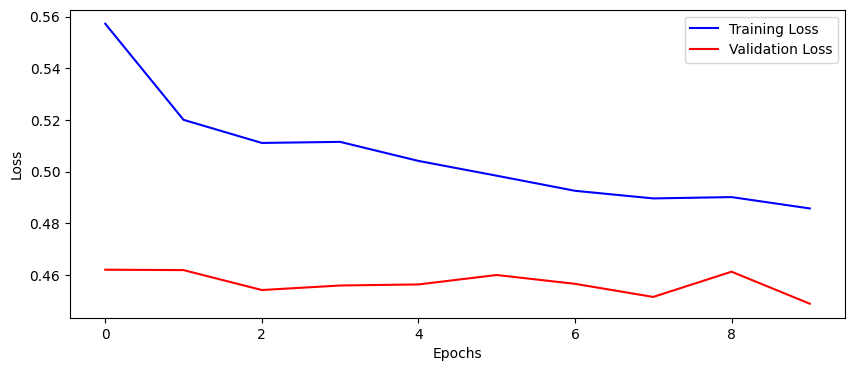

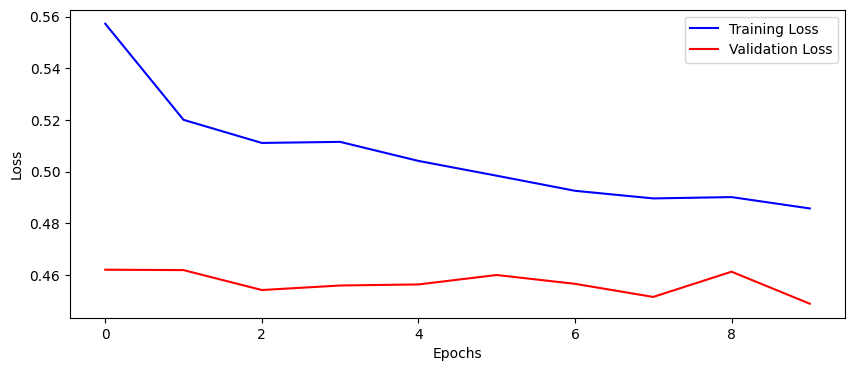

In [9]:
sbs.plot_losses("C:\\Users\\Abdou\\Documents\\POLYTECH\\4A\\PROJET_4A\\10000_10_freez_lr0001.png")



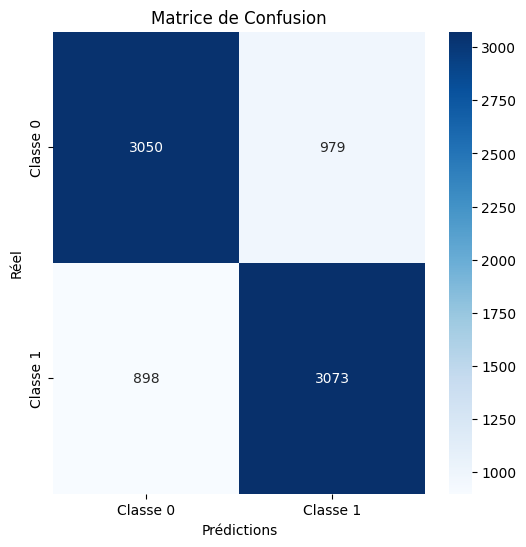

In [10]:
sbs.plot_confusion_matrix()

In [11]:
ds = load_dataset("PrkhrAwsti/Twitter_Sentiment_3M")
#On a pas besoin de la colonne unnamed
ds = ds.remove_columns("Unnamed: 0")

#On va prendre 100 000 tweets pour entrainer et tester notre model
ds = ds.shuffle(seed=48)
ds = ds["train"].select(range(10))

ds = ds.map(lambda example: {'label': example['sentiment'], 'text': example['tweet']}, remove_columns=['sentiment','tweet'])

In [12]:
test_data = TweetDataset(ds)
test_dataloader = DataLoader(test_data, batch_size=64)
sbs.predict(test_dataloader)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


{'accuracy': 0.6}

In [13]:
sbs.metrics(test=True)

{'f1_score': 0.6, 'accuracy': 0.6, 'roc_auc': np.float64(0.625)}

In [14]:
dataset = load_dataset("alpindale/two-million-bluesky-posts")

Resolving data files:   0%|          | 0/23 [00:00<?, ?it/s]

In [15]:
class OtherDataset(Dataset):
    def __init__(self, encodings,
                 tokenizer=torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased'),
                 max_length=180):
        self.encodings = encodings
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __getitem__(self, index):
        text = self.encodings.iloc[index] if hasattr(self.encodings, 'iloc') else self.encodings[index]
        inputs = self.tokenizer(
            text=text['text'],
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )
        target = text['label']
        # Use string comparison for labels
        target = 0 if target == 'Negative' else 1# if target == 'Positive' else [0, 0,1 ]
        
        return {
            'ids': inputs['input_ids'].squeeze(0).to(self.device),
            'token_type_ids': inputs['token_type_ids'].squeeze(0).to(self.device),
            'attention_mask': inputs['attention_mask'].squeeze(0).to(self.device),
            'target': torch.tensor(target, dtype=torch.float).to(self.device)
        }

    def __len__(self):
        return len(self.encodings)

Using cache found in C:\Users\Abdou/.cache\torch\hub\huggingface_pytorch-transformers_main


In [16]:

import pandas as pd
df = pd.read_csv('bluesky.csv')
df = df.drop(['Unnamed: 0','score'],axis=1)
df = df[df['label'].isin(['Positive', 'Negative'])]
test_data = OtherDataset(df)
test_dataloader = DataLoader(test_data, batch_size=64)
sbs.predict(test_dataloader)


100%|████████████████████████████████████████████████████████████████████████████████| 147/147 [00:50<00:00,  2.93it/s]


{'accuracy': 0.5775292864749734}

In [17]:
sbs.metrics(test=True)

{'f1_score': 0.5930029752744435,
 'accuracy': 0.5775292864749734,
 'roc_auc': np.float64(0.6049574199878149)}

In [18]:
from datasets import load_dataset

ds = load_dataset("cardiffnlp/tweet_sentiment_multilingual", "english")
test = TweetDataset(ds["train"].filter(lambda exemple: exemple['label'] in [0, 2]))
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE)
sbs.predict(test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.87it/s]


{'accuracy': 0.5975885455915599}

In [19]:
sbs.metrics(test=True)

{'f1_score': 0.6147880973850316,
 'accuracy': 0.5975885455915599,
 'roc_auc': np.float64(0.6212704330772459)}

In [20]:
sbs.save_checkpoint('modele_5epochs_100000tweets')